## Analisis data demand 

Melakukan analisis data demand dari data ... data mencatat demand setiap 15 menit selama 2 bulan. Tanggal tidak diberitahukan secara spesifik

In [23]:
import pandas as pd
import numpy
import time as tm
import datetime as dt
import geohash
from datetime import datetime 
import matplotlib
import matplotlib.pyplot as plt
import folium
import seaborn as sb



Function
#datetime : untuk mengubah data yang menunjukkan hari-ke (day) berubah menjadi tanggal. Sehingga lebih mudah untuk melakukan analisa

#combine_day_time : menggabungkan timestamp dan data date.

In [24]:
import datetime
def days_to_datetime(day):
    if day < 31 :
        date = datetime.date(2019,9, day)
#         print(day)
    if day > 30 :
        day = day-30
#         print (day)
        date = datetime.date(2019,10,day)
#         print(day)
    if day > 61 :
        day= day-61
        date = datetime.date(2019,11, day)
#         print(day)
    return date

def combine_day_time(x):
    timestamp = dt.datetime.combine(x[0],x[1])
    return timestamp



read file training.csv dan diurutkan berdasarkan hari

In [25]:
data =  pd.read_csv('training.csv')
data.head()
data = data.sort_values(by=['day'])
# data['timestamp'] = pd.to_datetime(data['timestamp'],format= '%H:%M').dt.time
# data['timestamp'] =  data['timestamp'].map(lambda x:datetime.strptime(x,'%H:%M').time())

data.head()

,geohash6,day,timestamp,demand
1397619,qp03wk,1,15:0,0.014157
578766,qp03qq,1,6:0,0.065150
1764752,qp03pc,1,6:0,0.006745
1394806,qp09g2,1,1:30,0.117315
1394835,qp09bm,1,10:45,0.088563


Decoding geohash to longitude and latitude 

In [26]:
data['location']= data['geohash6'].apply(lambda x: geohash.decode(x))
data[['latitude', 'longitude']] = pd.DataFrame(data['location'].tolist(), index=data.index)
data = data.drop(['location'],axis=1)


In [27]:
data['date'] = data['day'].apply(lambda x :days_to_datetime(x))
data['datetime'] = pd.to_datetime(data['date'].apply(str)+' '+data['timestamp'])

In [28]:

data= data.set_index(data['datetime'])
data['hour'] = data.index.hour
data['minute'] = data.index.minute

print(type(data.datetime))
data.head()

<class 'pandas.core.series.Series'>


,geohash6,day,timestamp,demand,latitude,longitude,date,datetime,hour,minute
datetime,,,,,,,,,,
2019-09-01 15:00:00,qp03wk,1,15:0,0.014157,-5.336609,90.631714,2019-09-01,2019-09-01 15:00:00,15,0
2019-09-01 06:00:00,qp03qq,1,6:0,0.065150,-5.369568,90.631714,2019-09-01,2019-09-01 06:00:00,6,0
2019-09-01 06:00:00,qp03pc,1,6:0,0.006745,-5.440979,90.697632,2019-09-01,2019-09-01 06:00:00,6,0
2019-09-01 01:30:00,qp09g2,1,1:30,0.117315,-5.314636,90.851440,2019-09-01,2019-09-01 01:30:00,1,30
2019-09-01 10:45:00,qp09bm,1,10:45,0.088563,-5.287170,90.719604,2019-09-01,2019-09-01 10:45:00,10,45


In [29]:

data = data.drop(['date','datetime', 'timestamp'], axis=1)
data['dow'] = data['day'] % 7
data.to_csv('data_after_prep.csv')
data.head()


,geohash6,day,demand,latitude,longitude,hour,minute,dow
datetime,,,,,,,,
2019-09-01 15:00:00,qp03wk,1,0.014157,-5.336609,90.631714,15,0,1
2019-09-01 06:00:00,qp03qq,1,0.065150,-5.369568,90.631714,6,0,1
2019-09-01 06:00:00,qp03pc,1,0.006745,-5.440979,90.697632,6,0,1
2019-09-01 01:30:00,qp09g2,1,0.117315,-5.314636,90.851440,1,30,1
2019-09-01 10:45:00,qp09bm,1,0.088563,-5.287170,90.719604,10,45,1


In [45]:
# outlier from day
zscore = lambda x: (x - x.mean()) / x.std()
data['zscore_day'] = np.abs(data.groupby('day')['demand'].transform(zscore))
print("number of suspected outliers from day", len(data[data['zscore_day'] > 3]))

number of suspected outliers from day 112915


In [48]:
data['zscore_timestamp'] = np.abs(data.groupby('datetime')['demand'].transform(zscore))
print("number of suspected outliers from timestamp", len(data[data['zscore_timestamp'] > 3]))

number of suspected outliers from timestamp 117476


In [51]:
_ = data[(data['zscore_day'] <= 3) & (data['zscore_timestamp'] <= 3)].groupby(['dow','hour'], as_index=False)\
.agg({'demand':'mean'})\
.sort_values(by=['dow','hour'])

In [52]:
_.head()

,dow,hour,demand
0,0,0,0.084293
1,0,1,0.087979
2,0,2,0.085010
3,0,3,0.090237
4,0,4,0.095500


In [56]:

import plotly
plotly.__version__
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = [
    go.Heatmap(
        z=_['demand'].values.reshape((7,24)),
        x=[str(i) for i in range(24)],
        y=[str(i) for i in range(7)],
        #colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Average Demand in Day of Week x 24 hours',
    xaxis=dict(
        title='Hours',
    ),
    yaxis=dict(
        title='Day of Week',
    ),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## analysis start

In [30]:
start_date = '2019-09-01'
end_date = '2019-09-30'
mask = (data.index > start_date) & (data.index <= end_date)
data_month_1 = data.loc[mask]

data_daily_min = data_month_1.groupby(['day','hour'])['demand'].sum()
df_pivot_minute = data_daily_min.reset_index()
df_pivot_minute = df_pivot_minute.pivot(index='day', columns='hour', values='demand')
df_pivot_minute.head()


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
1,108.460009,208.068747,269.916358,350.744153,373.504583,376.897100,391.669744,393.146101,409.920947,401.683262,...,322.676933,219.698574,133.556255,75.018198,51.141074,40.278005,46.955942,89.177877,173.296721,330.763236
2,425.874802,440.013560,405.213748,418.258593,457.333714,470.915578,453.271415,453.247776,457.768695,507.401243,...,287.283832,198.551020,131.049256,83.197707,57.613483,44.917863,45.472101,76.051748,146.573491,289.890459
3,383.903280,413.774604,384.068957,401.221693,449.887599,466.410225,455.869558,450.390980,452.580048,490.462919,...,305.938054,220.419412,151.415182,94.576457,67.774381,51.947929,53.096064,86.571407,155.817442,294.678388
4,386.455134,420.277711,406.923209,441.180930,532.254854,537.624198,540.931667,504.161642,545.074203,601.867254,...,393.810704,297.296388,210.565955,144.271891,111.091319,89.767301,78.923374,83.030238,99.551708,170.174195
5,208.701527,262.827697,305.935849,351.957990,392.891528,410.966362,427.002119,437.014702,422.372991,422.206630,...,311.123444,232.623979,161.109278,109.416327,82.844961,70.327429,62.285401,57.666698,61.040077,96.248955


Berikut hasil grafik demand selama 2 bulan pada setiap jamnya

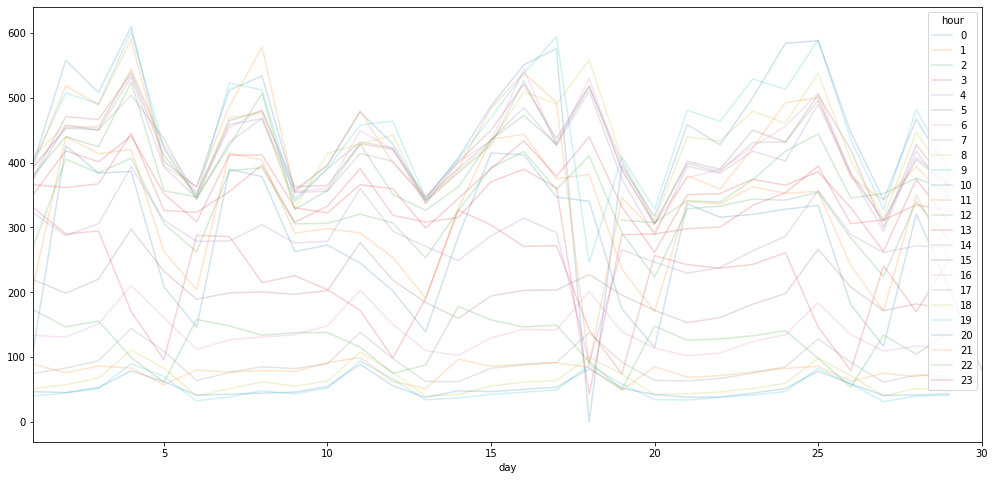

In [31]:
df_pivot_minute.plot(figsize=(17,8), legend=True, alpha=0.2)

dari heatmap ditunjukkan bahwa pada jam 8-11 merupakan demand terpadat ditunjukkan dengan warna heatmap yang semakin terang dan jam 19.00 -20.00 merupakan demand terendah

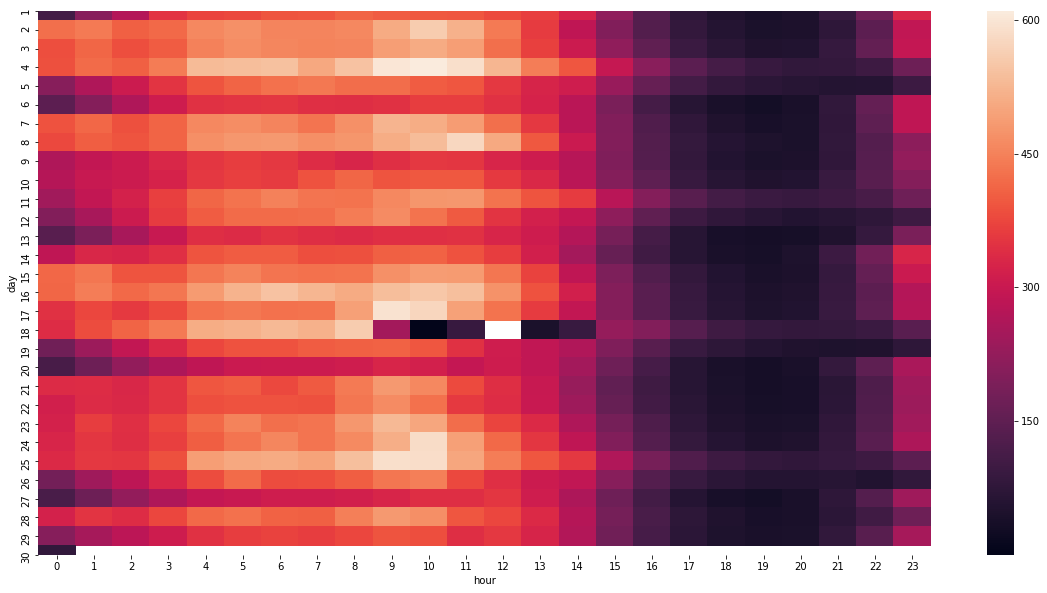

In [32]:
fig,ax = plt.subplots(figsize=(20,10))
heat_map = sb.heatmap(df_pivot_minute,ax=ax)

plt.show()

In [33]:
data_daily_min_ = data.groupby(['hour','minute'])['demand'].mean()
df_pivot_minute_ = data_daily_min_.reset_index()
df_pivot_minute_ = df_pivot_minute_.pivot(index='hour', columns='minute', values='demand')
df_pivot_minute_.head()


minute,0,15,30,45
hour,,,,
0,0.087615,0.090515,0.092895,0.093123
1,0.095381,0.097042,0.098525,0.097833
2,0.098141,0.098187,0.099167,0.099056
3,0.101835,0.104761,0.107830,0.111115
4,0.115787,0.116899,0.117151,0.117773


Semakin diperjelas pada grafik dibawah bahwa pukul 10 merupakan jam dengan demand tertinggi dan jam 20.00 adalah waktu dengan demand terendah

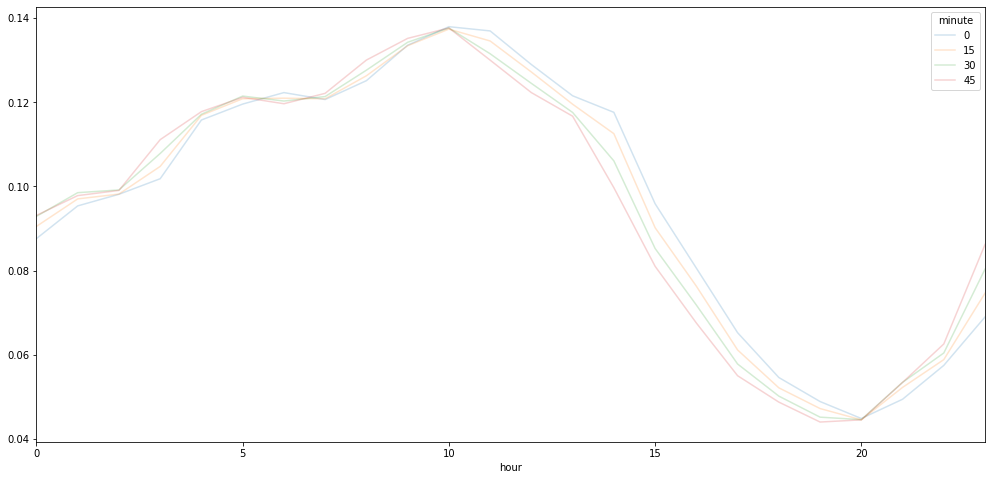

In [34]:
df_pivot_minute_.plot(figsize=(17,8), legend=True, alpha=0.2)

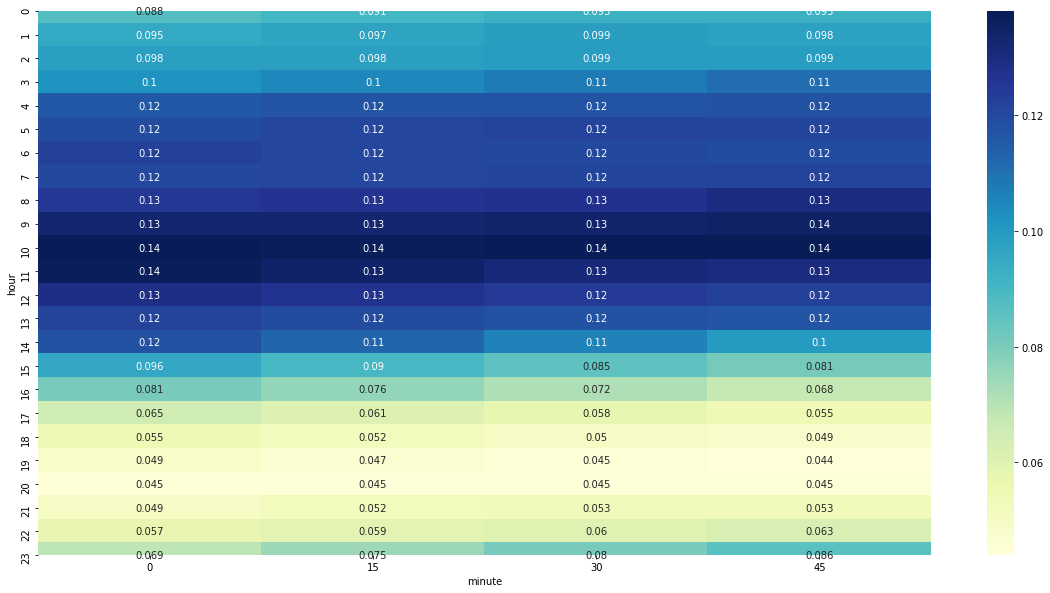

In [35]:
fig,ax = plt.subplots(figsize=(20,10))
heat_map_1 = sb.heatmap(df_pivot_minute_, annot=True, ax=ax, cmap="YlGnBu")
plt.show()

# DENSITY CHART

In [36]:
data.index

DatetimeIndex(['2019-09-01 15:00:00', '2019-09-01 06:00:00',
               '2019-09-01 06:00:00', '2019-09-01 01:30:00',
               '2019-09-01 10:45:00', '2019-09-01 06:30:00',
               '2019-09-01 10:15:00', '2019-09-01 07:00:00',
               '2019-09-01 14:00:00', '2019-09-01 03:30:00',
               ...
               '2019-10-31 18:15:00', '2019-10-31 05:45:00',
               '2019-10-31 00:15:00', '2019-10-31 08:30:00',
               '2019-10-31 00:45:00', '2019-10-31 02:15:00',
               '2019-10-31 02:30:00', '2019-10-31 12:15:00',
               '2019-10-31 13:00:00', '2019-10-31 12:45:00'],
              dtype='datetime64[ns]', name='datetime', length=4206321, freq=None)

In [37]:
start_date = '2019-09-01'
end_date = '2019-09-30'
mask = (data.index > start_date) & (data.index <= end_date)
data_month_1 = data.loc[mask]



start_date_1 = '2019-10-01'
end_date_1 = '2019-10-31'
mask = (data.index > start_date_1) & (data.index <= end_date_1)
data_month_2 = data.loc[mask]
data_month_2.head()
# df['new'] = np.where(df.p.dt.hour > 16, 'Delayed', 'On-time')

,geohash6,day,demand,latitude,longitude,hour,minute,dow
datetime,,,,,,,,
2019-10-01 05:30:00,qp09jp,31,0.075114,-5.408020,90.928345,5,30,3
2019-10-01 05:30:00,qp094w,31,0.001373,-5.413513,90.818481,5,30,3
2019-10-01 21:45:00,qp03qf,31,0.216378,-5.391541,90.653687,21,45,3
2019-10-01 00:30:00,qp0d5m,31,0.009865,-5.243225,90.851440,0,30,3
2019-10-01 04:30:00,qp03nf,31,0.000421,-5.435486,90.653687,4,30,3


In [38]:
geohashes_df = data_month_1.groupby('geohash6', as_index=False)\
.agg({'day':'count', 'demand':'sum'})\
.rename(columns={'day':'count'})\
.sort_values(by='count', ascending=False)
geohashes_df['lat'] = None
geohashes_df['lat_err'] = None
geohashes_df['long'] = None
geohashes_df['long_err'] = None
for i in range(len(geohashes_df)):
    geo_decoded = geohash.decode_exactly(geohashes_df.loc[i,'geohash6'])
    geohashes_df.loc[i,'lat'] = geo_decoded[0]
    geohashes_df.loc[i,'long'] = geo_decoded[1]
    geohashes_df.loc[i,'lat_err'] = geo_decoded[2]
    geohashes_df.loc[i,'long_err'] = geo_decoded[3]
geohashes_df.head()

,geohash6,count,demand,lat,lat_err,long,long_err
260,qp03xw,2774,2032.007322,-5.32562,0.00274658,90.6866,0.00549316
274,qp03yb,2774,1907.376520,-5.31464,0.00274658,90.6537,0.00549316
214,qp03wf,2774,1738.357511,-5.3476,0.00274658,90.6537,0.00549316
231,qp03wz,2774,1838.503380,-5.32013,0.00274658,90.6537,0.00549316
320,qp03zv,2773,1026.867127,-5.28717,0.00274658,90.6976,0.00549316


Text(0.5, 1.0, 'Density of demand by location month 1')

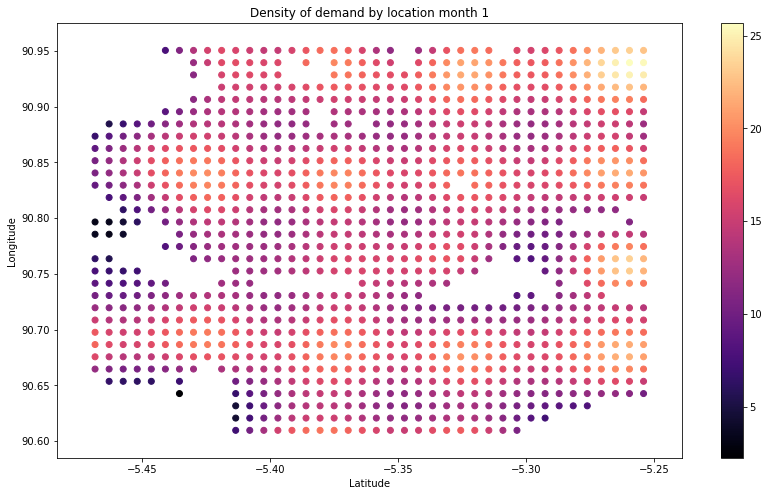

In [39]:
import numpy as np
from scipy.interpolate import interpn

x = geohashes_df['lat'].values
y = geohashes_df['long'].values
plt.figure(figsize=(14,8))
data_df , x_e, y_e = np.histogram2d( x, y)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), 
            data_df , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x, y, c=z, cmap='magma')
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Density of demand by location month 1')

In [40]:
geohashes_df_2 = data_month_2.groupby('geohash6', as_index=False)\
.agg({'day':'count', 'demand':'sum'})\
.rename(columns={'day':'count'})\
.sort_values(by='count', ascending=False)
geohashes_df_2['lat'] = None
geohashes_df_2['lat_err'] = None
geohashes_df_2['long'] = None
geohashes_df_2['long_err'] = None
for i in range(len(geohashes_df_2)):
    geo_decoded_2 = geohash.decode_exactly(geohashes_df_2.loc[i,'geohash6'])
    geohashes_df_2.loc[i,'lat'] = geo_decoded_2[0]
    geohashes_df_2.loc[i,'long'] = geo_decoded_2[1]
    geohashes_df_2.loc[i,'lat_err'] = geo_decoded_2[2]
    geohashes_df_2.loc[i,'long_err'] = geo_decoded_2[3]
geohashes_df_2.head()

,geohash6,count,demand,lat,lat_err,long,long_err
739,qp09b7,2880,743.584166,-5.29816,0.00274658,90.7196,0.00549316
320,qp03zt,2880,590.600201,-5.28717,0.00274658,90.6866,0.00549316
309,qp03zf,2880,373.460842,-5.30365,0.00274658,90.6976,0.00549316
306,qp03zc,2880,436.848849,-5.30914,0.00274658,90.6976,0.00549316
227,qp03wu,2880,968.971257,-5.33661,0.00274658,90.6537,0.00549316


Text(0.5, 1.0, 'Density of demand by location month 2')

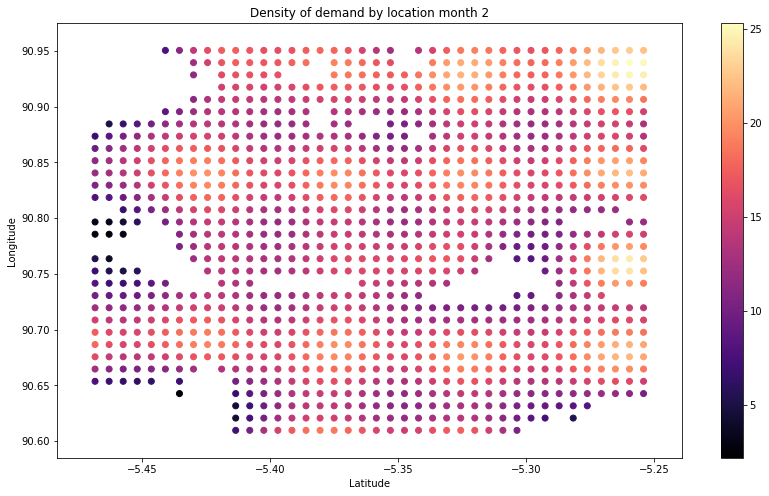

In [41]:
import numpy as np
from scipy.interpolate import interpn

x = geohashes_df_2['lat'].values
y = geohashes_df_2['long'].values
plt.figure(figsize=(14,8))
data_df , x_e, y_e = np.histogram2d( x, y)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), 
            data_df , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x, y, c=z, cmap='magma')
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Density of demand by location month 2')

Berdasarkan grafik dibawah demand tertinggi berada pada posisi lat -5.353 dan long 90.8185

In [42]:
geohashes_df.sort_values(by=['demand'], ascending=False).head()

,geohash6,count,demand,lat,lat_err,long,long_err
786,qp09d9,2772,2335.171309,-5.35309,0.00274658,90.8185,0.00549316
261,qp03xx,2773,2074.433789,-5.32013,0.00274658,90.6866,0.00549316
813,qp09e5,2773,2056.926509,-5.3421,0.00274658,90.8405,0.00549316
260,qp03xw,2774,2032.007322,-5.32562,0.00274658,90.6866,0.00549316
274,qp03yb,2774,1907.376520,-5.31464,0.00274658,90.6537,0.00549316


## predicting

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
